# PHAS0102 - Assignment 3 (19002781)

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import coo_matrix
import numba
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng

from timeit import timeit

## Part 1: Implementing a CSR matrix

### Defining CSR class

In [2]:
class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):
        
        """
        Converts a COO matrix to a CSR matrix.
        
        """
        
        # Initialising conditions
        self.shape = coo_matrix.shape
        self.dtype = coo_matrix.dtype
        
        row = coo_matrix.row
        col = coo_matrix.col
        data = coo_matrix.data
        
        # Implement sort
        order = np.argsort(row)
        row = row[order]
        col = col[order]
        data = data[order]
        
        # Generate indpt
        indptr = [0]
        point = 0
        
        for i in range(0,self.shape[0]-1):
            point += np.count_nonzero(row == i)
            indptr.append(point)      
        
        indptr.append(len(row))
        
        self.indptr = indptr
        self.indices = col
        self.data = data
        
    def __add__(self, other):
        """
        Adds two CSR matrices and returns a CSR matrix.
        
        """
        
        assert self.shape == other.shape
    
        # mat 1 CSR to COO

        indptr1 = self.indptr
        indices1 = self.indices
        data1 = self.data

        col1 = indices1

        row1 = np.empty(0,dtype=np.int32)

        last_row = 0
        for i in range(len(indptr1)-1):
            diff = indptr1[i+1] - indptr1[i]
            for j in range(diff):
                row1 = np.append(row1, last_row)
            last_row += 1


        # mat 2 CSR to COO

        indptr2 = other.indptr
        indices2 = other.indices
        data2 = other.data

        col2 = indices2

        row2 = np.empty(0,dtype=np.int32)

        last_row = 0
        for i in range(len(indptr2)-1):
            diff = indptr2[i+1] - indptr2[i]
            for j in range(diff):
                row2 = np.append(row2, last_row)
            last_row += 1

        # Add COO matrices

        row_sum = row1
        col_sum = col1
        data_sum = data1
        indexes = []

        for j in range(len(row1)):
            for i in range(len(row2)):
                if (row1[j],col1[j]) == (row2[i],col2[i]):
                    data_sum[j] += data2[i]
                    
                    indexes.append(i)

        indexes.sort(reverse=True)
        
        for i in indexes:
            data2 = np.delete(data2,i)
            row2 = np.delete(row2, i)
            col2 = np.delete(col2, i)

        row_sum = np.append(row_sum, row2)
        col_sum = np.append(col_sum, col2)
        data_sum = np.append(data_sum, data2)

        row_sum = np.array(row_sum)
        col_sum = np.array(col_sum)
        data_sum = np.array(data_sum)

        del_list = []

        for i in range(len(data_sum)):
            if data_sum[i] == 0:
                del_list.append(i)

        for j in del_list:
            data_sum = np.delete(data_sum, j)
            row_sum = np.delete(row_sum, j)
            col_sum = np.delete(col_sum, j)

        coo_mat = coo_matrix((data_sum, (row_sum, col_sum)), shape=(self.shape))
        
        # Convert COO to CSR
        csr_mat = CSRMatrix(coo_mat)

        return csr_mat
    
    def _matvec(self, vector):
        """
        Computes a matrix-vector product.
        
        """
        
        assert self.shape[1] == vector.shape[0]
        
        self.dtype = vector.dtype
        
        indptr = self.indptr
        indices = self.indices
        data = self.data
        
        shape = self.shape[1]
        
        output = np.zeros(shape)
        
        for row_ind in range(shape):
            col_start = indptr[row_ind]
            col_end = indptr[row_ind + 1]
            for col_ind in range(col_start, col_end):
                output[row_ind] += data[col_ind] * vector[indices[col_ind]]
                
        return output

### Checking add

In [3]:
# Random sparse matrix
A = scipy.sparse.random(5,5,density=0.25)
A_coo = coo_matrix(A)
print(A.toarray())

[[0.70155549 0.         0.         0.         0.        ]
 [0.         0.         0.         0.4984074  0.        ]
 [0.         0.         0.23999058 0.         0.60504045]
 [0.         0.         0.         0.         0.        ]
 [0.5808298  0.         0.         0.4075571  0.        ]]


In [4]:
# Random sparse matrix
B = scipy.sparse.random(5,5,density=0.25)
B_coo = coo_matrix(B)
print(B.toarray())

[[0.         0.         0.         0.         0.        ]
 [0.75476778 0.         0.         0.         0.        ]
 [0.92650539 0.         0.         0.56609441 0.32826256]
 [0.         0.         0.99986766 0.         0.        ]
 [0.         0.88118665 0.         0.         0.        ]]


In [5]:
# Perform addition
C = A + B
C = C.toarray()
print(C)

[[0.70155549 0.         0.         0.         0.        ]
 [0.75476778 0.         0.         0.4984074  0.        ]
 [0.92650539 0.         0.23999058 0.56609441 0.93330302]
 [0.         0.         0.99986766 0.         0.        ]
 [0.5808298  0.88118665 0.         0.4075571  0.        ]]


In [6]:
# Compute csr addition
A_csr = CSRMatrix(A_coo)
B_csr = CSRMatrix(B_coo)

C_csr = A_csr + B_csr
C_csr_add = csr_matrix((C_csr.data,C_csr.indices,C_csr.indptr), shape = A.shape).toarray()

In [7]:
# Checking add function
assert np.allclose(C, C_csr_add)

### Checking matvec

In [8]:
# Random sparse matrix
A2 = scipy.sparse.random(5,5,density=0.4)
A2_coo = coo_matrix(A2)
A2_csr = CSRMatrix(A2_coo)

print(A2.toarray())

[[0.43194628 0.         0.39708085 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.64933485 0.         0.2106224  0.21740849]
 [0.18375427 0.         0.         0.         0.05898488]
 [0.         0.62090445 0.84251086 0.63840293 0.        ]]


In [9]:
# Random vector
B2 = np.random.rand(5,1)

print(B2)

[[0.40476032]
 [0.1041556 ]
 [0.02019463]
 [0.52118507]
 [0.60534177]]


In [10]:
# Computing matvec
C2 = A2 @ B2

print(C2)

[[0.18285362]
 [0.        ]
 [0.30901154]
 [0.11008245]
 [0.41441094]]


In [11]:
# Computing csr matvec
C2_csr = A2_csr @ B2

print(C2_csr)

[[0.18285362]
 [0.        ]
 [0.30901154]
 [0.11008245]
 [0.41441094]]


In [12]:
# Checking matvec
assert np.allclose(C2, C2_csr)

### Time taken for various matvec products

In [13]:
# Timing different matvec products
n = np.arange(1,1001,10)

matvec_times = []
numpy_times = []

for i in n:
    # Create matrices
    next_mat_coo = scipy.sparse.random(i,i,density=0.5)
    next_mat_csr = CSRMatrix(next_mat_coo)
    next_mat_dense = next_mat_coo.toarray()
    next_vector = np.random.rand(i,1)
    
    # Time calculations
    next_matvec_time = timeit('next_mat_csr @ next_vector',globals=globals(),number=1)
    matvec_times.append(next_matvec_time)
    
    next_numpy_time = timeit('np.dot(next_mat_dense, next_vector)',globals=globals(),number=1)
    numpy_times.append(next_numpy_time)

In [14]:
# Measuring constant of matvec fit
A = np.polyfit(n, matvec_times, 2)[0]
print(A)

2.3251394701895196e-06


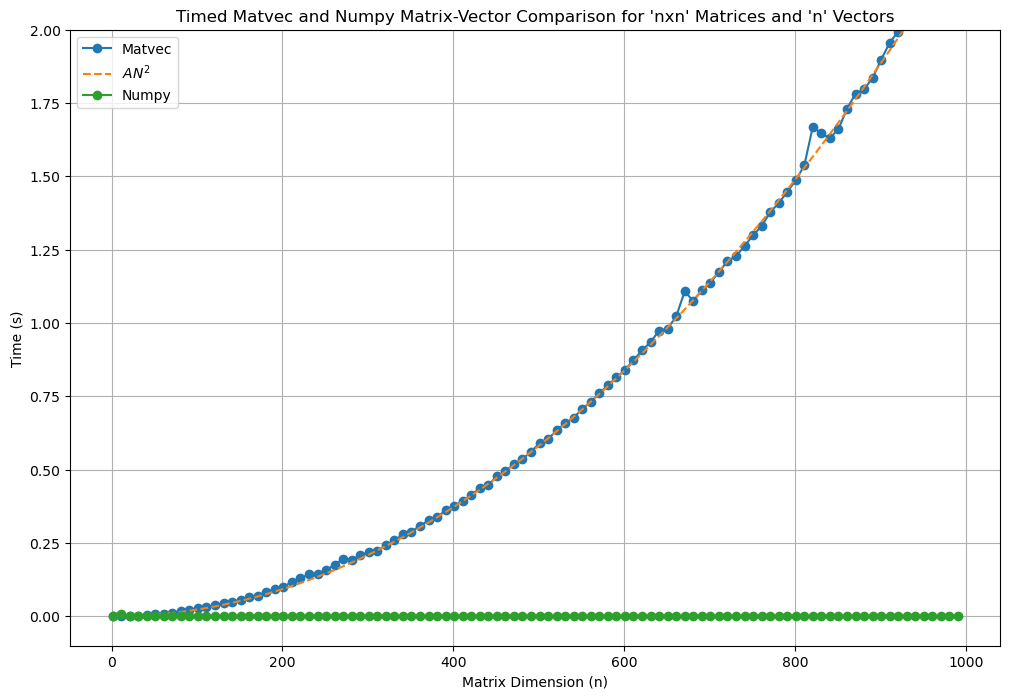

In [15]:
# Plotting run times of matvec and numpy matrix product functions
fig1 = plt.figure(figsize=(12,8))

ax1 = fig1.add_subplot(111)

ax1.plot(n, matvec_times, '-o', label="Matvec")
ax1.plot(n, A*n**2 , '--', label="$AN^{2}$")
ax1.plot(n, numpy_times, '-o', label="Numpy")

ax1.set_ylim(-0.1,2)

ax1.set_title("Timed Matvec and Numpy Matrix-Vector Comparison for 'nxn' Matrices and 'n' Vectors")
ax1.set_xlabel("Matrix Dimension (n)")
ax1.set_ylabel("Time (s)")

plt.legend()
plt.grid()
plt.show()

It is clear that the numpy dense matrix-vector product is faster when computing matrix-vector product calculations. It can also be seen that the Matvec function from the CSRMatrix(LinearOperator) class scales like to An$^{2}$ where the constant A is ~ 2e-6. This is due to the double 'for loop' in _matvec which strongly suggests an n$^{2}$ scaling as there are n$^{2}$ calculations for the _matvec function.

In [16]:
# Freeing up space
del matvec_times
del numpy_times

### Gmres and cg sparse solvers to solve Ax=b

In [17]:
# Creating matrix and vector
size = 5

A = scipy.sparse.random(size,size,density=0.6)
A_csr = CSRMatrix(A)

b = np.random.rand(size)

print(A.toarray(),"\n")

print(b)

[[0.98185322 0.         0.         0.9580283  0.35107276]
 [0.         0.59741919 0.25417886 0.337776   0.51834767]
 [0.         0.5579737  0.         0.45749698 0.14968707]
 [0.63694598 0.         0.55436462 0.         0.33849484]
 [0.97057195 0.         0.         0.         0.10094773]] 

[0.27921012 0.95835956 0.66498824 0.90861662 0.17237998]


In [18]:
# Gmres
x_gmres, exitCode_gmres = scipy.sparse.linalg.gmres(A_csr, b)
print(x_gmres)

[ 0.21639992  1.12266619  1.61813021  0.2063416  -0.37298229]


In [19]:
# Check gmres
assert np.allclose(np.dot(A.toarray(),x_gmres), b)

In [20]:
# Cg
x_cg, exitCode_cg = scipy.sparse.linalg.cg(A_csr, b)
print(x_cg)

[ 94.27317394 -71.78110759 -14.68795633 -87.72107668 -43.32211169]


In [21]:
# Check cg
assert np.allclose(np.dot(A.toarray(),x_cg), b)

AssertionError: 

Cg requires that the matrix is symmetric positive definite, therefore unless the randomly generated matrix satisfies this condition (which is highly unlikely), cg will not work. Gmres however, works for most matrices when solving Ax=b which is supported by the successful 'assert' statement. 

## Part 2: Implementing a custom matrix

### Defining custom class

In [22]:
class CustomMatrix(LinearOperator):
    def __init__(self, diag, T, W):
        
        """
        Initialises matrix A.
        
        """
        
        # Ensuring appropirate shapes
        assert T.shape == (W.T).shape
        assert diag.shape[0] == T.shape[0]
        assert W.shape[0] == 2
        assert T.shape[1] == 2
        
        # Initialises A properties
        self.shape = (2*diag.shape[0],2*diag.shape[0])
        self.dtype = T.dtype
        self.diag = diag
        self.A_tilde = T @ W
        self.Tarray = T
        self.Warray = W
        
    def _matvec(self, vector):
        """
        Computes A @ vector.
        
        """
        
        # Checking dimensions
        assert self.shape[1] == vector.shape[0]
        
        # Initialising vector dtype
        vector.dtype == self.dtype
        
        # Computing matrix vector product components
        diag_part = self.diag * vector[0:int(len(vector)*0.5)]
        A_tilde_part = np.dot(self.Tarray, np.dot(self.Warray, vector[int(len(vector)*0.5):]))
        
        output = np.append(diag_part,A_tilde_part)
        
        return output

In [23]:
# Creating random arrays to test CustomMatrix()
n = 10

diag = np.random.rand(n)
T = np.random.rand(n,2)
W = np.random.rand(2,n)

A_tilde = T @ W

vec = np.random.rand(2*n)

In [24]:
# Generating a custom matrix
mat = CustomMatrix(diag,T,W)

product = mat @ vec

In [25]:
# Creating a dense matrix for comparison
dense = np.zeros((2*n, 2*n))

for i in range(n):
    dense[i][i] = diag[i]

for i in range(n,2*n):
    for j in range(n,2*n):
        dense[i][j] = A_tilde[i-n][j-n]

In [26]:
# Checking dense matvec product
dense_product = dense @ vec

In [27]:
# Assuring CustomMatrix() provides correct solution
assert np.allclose(product, dense_product)

### Comparing times for matrix vector products

In [28]:
# Creating dense matrices

n = np.arange(1,1002,1)

diag_array = []
T_array = []
W_array = []
A_tilde_array = []
vec_array = []

custom_array = []
dense_array = []

# Creating components of dense matrix and custom matrix
for i in range(len(n)):
    dense_next = np.zeros((2*i, 2*i))
    dense_array.append(dense_next)

# Deleting first element as it is a scalar
del dense_array[0]

for i in range(len(n)):
    diag_next = np.random.rand(i)
    diag_array.append(diag_next)

del diag_array[0]
    
for i in range(len(n)):
    T_next = np.random.rand(i,2)
    T_array.append(T_next)
    
    W_next = np.random.rand(2,i)
    W_array.append(W_next)
    
    A_tilde_next = T_next @ W_next
    A_tilde_array.append(A_tilde_next)
    
del T_array[0]
del W_array[0]
del A_tilde_array[0]
    
for i in range(len(n)):
    vec_next = np.random.rand(2*i)
    vec_array.append(vec_next)

del vec_array[0]

# Add diag arrays to dense matrices
for i in range(len(n)-1):
    for j in range(n[i]):
        dense_array[i][j][j] = diag_array[i][j]

# Add A_tilde arrays to dense matrices
for i in range(len(n)-1): 
    for j in range(n[i],2*n[i]):
        for k in range(n[i],2*n[i]):
            dense_array[i][j][k] = A_tilde_array[i][j-n[i]][k-n[i]]

# Create custom matrices
for i in range(len(n)-1):
    next_custom = CustomMatrix(diag_array[i], T_array[i], W_array[i])
    custom_array.append(next_custom)

In [29]:
# Measure time taken
custom_times = []
dense_times = []

for i in range(len(n)-1):
    next_custom_time = timeit('custom_array[i] @ vec_array[i]',globals=globals(),number=1)
    custom_times.append(next_custom_time)
    
    next_dense_time = timeit('dense_array[i] @ vec_array[i]',globals=globals(),number=1)
    dense_times.append(next_dense_time)

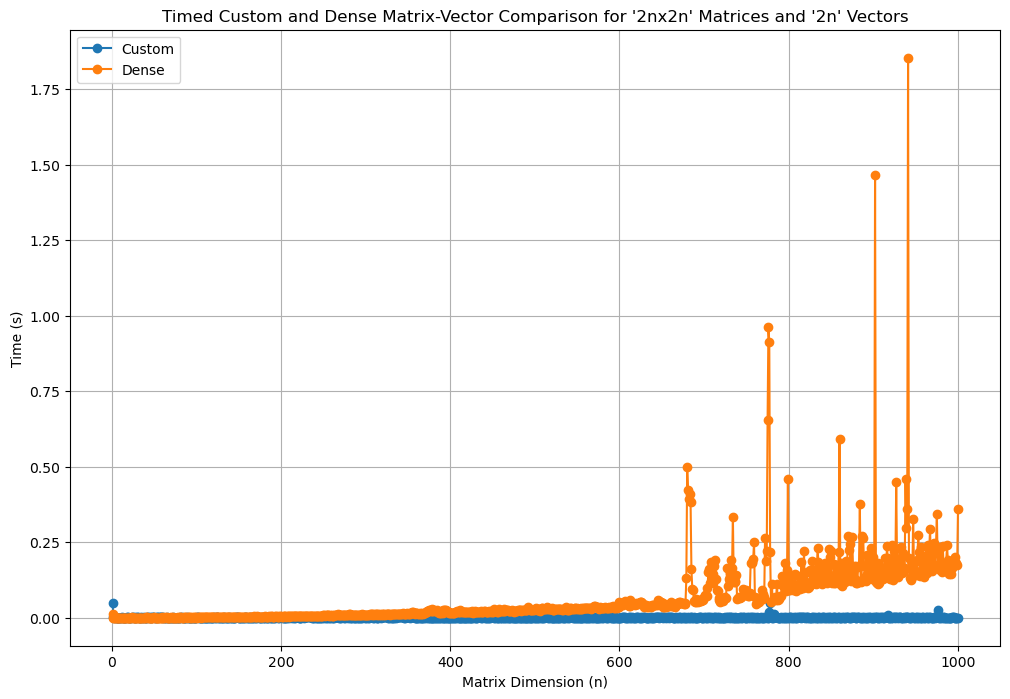

In [30]:
# Plotting run times of custom and dense matrix product functions
fig2 = plt.figure(figsize=(12,8))

ax1 = fig2.add_subplot(111)

ax1.plot(n[:len(n)-1],custom_times,'-o',label="Custom")
ax1.plot(n[:len(n)-1],dense_times,'-o',label="Dense")

ax1.set_title("Timed Custom and Dense Matrix-Vector Comparison for '2nx2n' Matrices and '2n' Vectors")
ax1.set_xlabel("Matrix Dimension (n)")
ax1.set_ylabel("Time (s)")

plt.legend()
plt.grid()
plt.show()

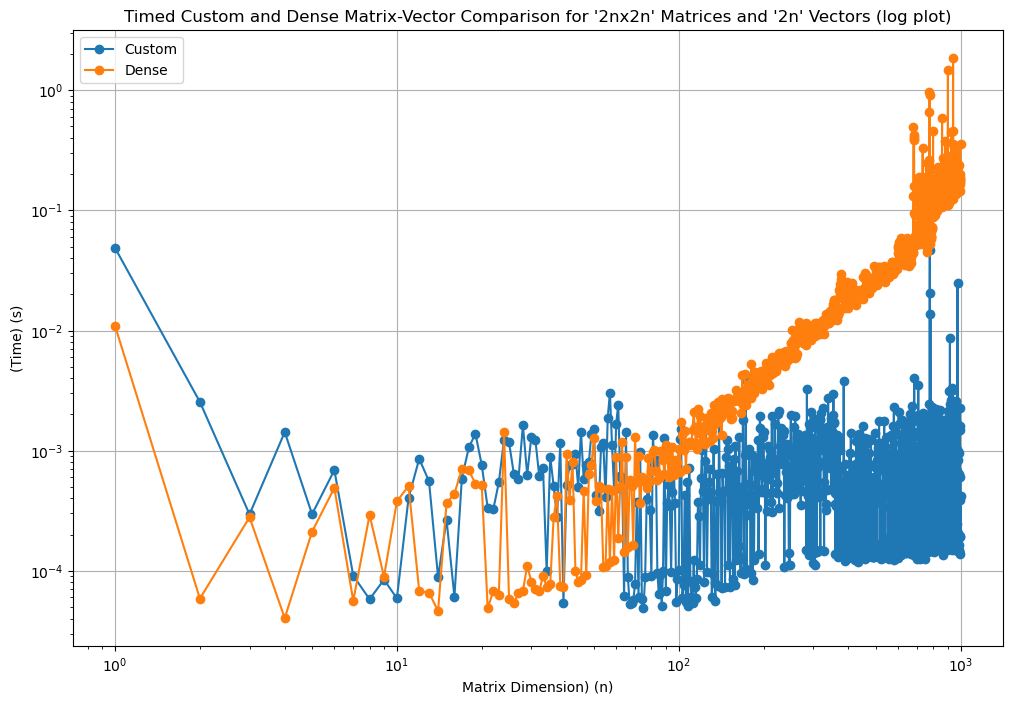

In [31]:
# Plotting log plot of run times of custom and dense matrix product functions
fig3 = plt.figure(figsize=(12,8))

ax1 = fig3.add_subplot(111)

ax1.plot(n[:len(n)-1],custom_times,'-o',label="Custom")
ax1.plot(n[:len(n)-1],dense_times,'-o',label="Dense")

ax1.set_title("Timed Custom and Dense Matrix-Vector Comparison for '2nx2n' Matrices and '2n' Vectors (log plot)")
ax1.set_xlabel("Matrix Dimension) (n)")
ax1.set_ylabel("(Time) (s)")

ax1.set_yscale('log')
ax1.set_xscale('log')

plt.legend()
plt.grid()
plt.show()

It is clear that for larger matrix sizes, the custom matrix format is faster when performing a matrix-vector product calculation than the standard dense Numpy format. One reason for this is the A_tilde calculation in _matvec, which avoids directly using A_tilde (which is an nxn matrix) and individually takes the dot product between T and (W.vector). This reduces the number of calculations and therefore speeds up the performance.

This is also due to a reduction in the number of individual calculations, as the custom matrix format only calls for the diagonal elements in the top left quadrant as well as the A_tilde elements in the bottom right quadrant when performing the calculation with the vector. However, the dense matrix format performs each individual calculation despite the top right and bottom left quadrants being exclusively populated by zeroes. This means that the dense product method scales approximately as 4n$^{2}$ while the custom product method scales by ~ n + Bn$^{2}$, where B ~ 1. The true scaling is likely to be lower than this due to the reasons discussed in the first paragraph.

In [32]:
# Further analysis into matrix-vector scaling
custom_elements_for_calculations = []
dense_elements_for_calculations = []

for i in range(len(n)-1):
    next_custom = np.count_nonzero(dense_array[i])
    custom_elements_for_calculations.append(next_custom)
    
    next_dense = dense_array[i].size
    dense_elements_for_calculations.append(next_dense)

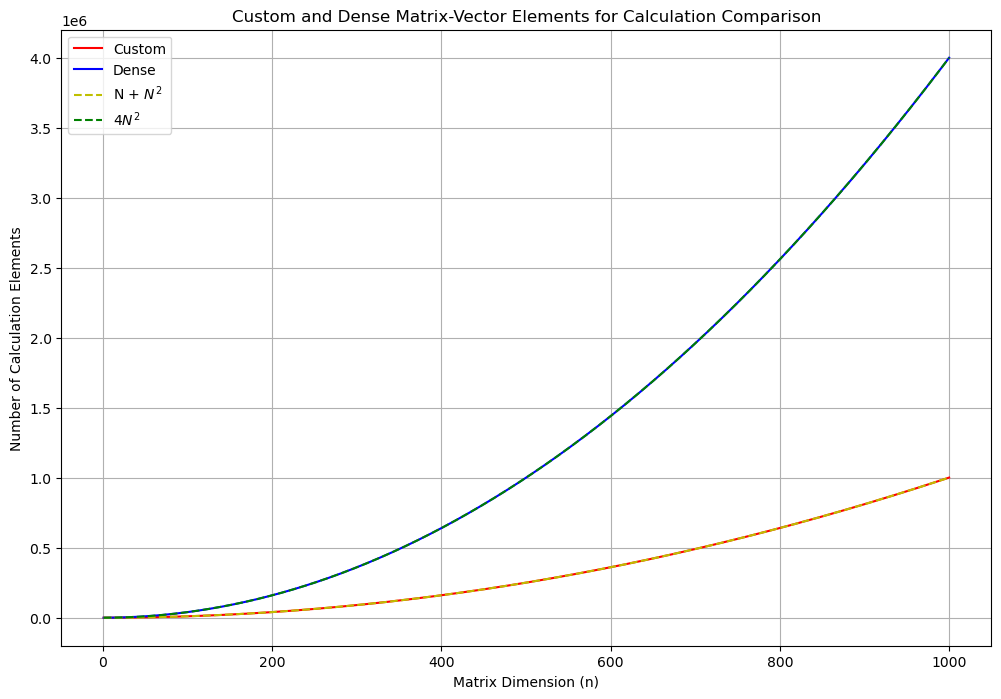

In [33]:
# Plotting calculation elements
fig4 = plt.figure(figsize=(12,8))

ax1 = fig4.add_subplot(111)

ax1.plot(n[:len(n)-1],custom_elements_for_calculations,'-r',label="Custom")
ax1.plot(n[:len(n)-1],dense_elements_for_calculations,'-b',label="Dense")
ax1.plot(n[:len(n)-1],n[:len(n)-1] + n[:len(n)-1]**2,'--y',label="N + $N^{2}$")
ax1.plot(n[:len(n)-1],4*n[:len(n)-1]**2,'--g',label="$4N^{2}$")

ax1.set_title("Custom and Dense Matrix-Vector Elements for Calculation Comparison")
ax1.set_xlabel("Matrix Dimension (n)")
ax1.set_ylabel("Number of Calculation Elements")

plt.legend()
plt.grid()
plt.show()

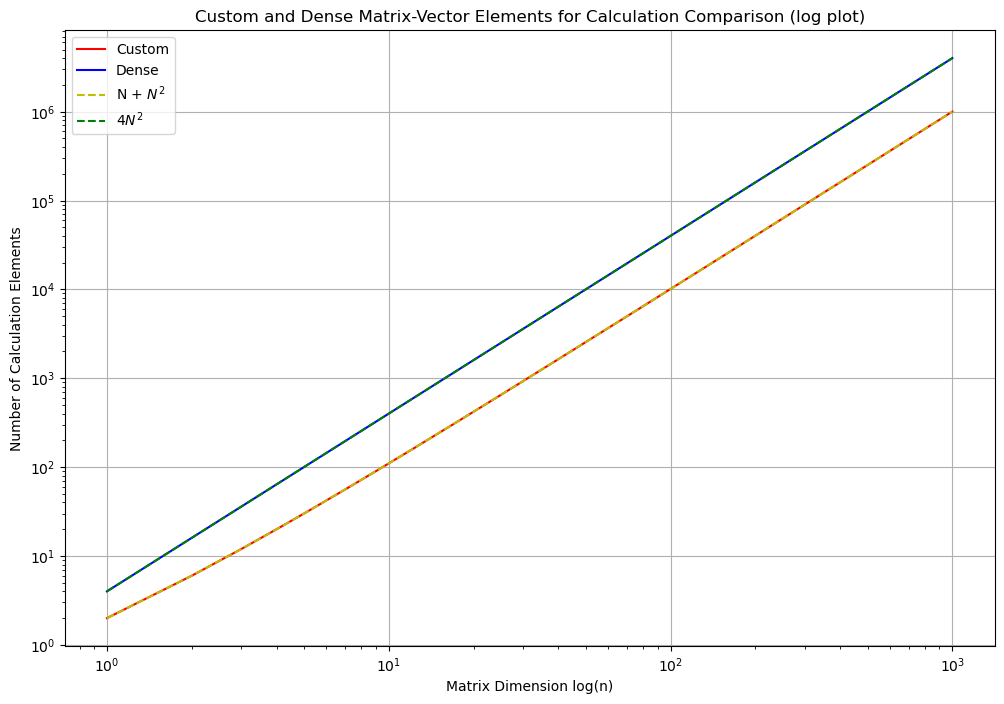

In [34]:
# Plotting calculation elements (log)
fig5 = plt.figure(figsize=(12,8))

ax1 = fig5.add_subplot(111)

ax1.plot(n[:len(n)-1],custom_elements_for_calculations,'-r',label="Custom")
ax1.plot(n[:len(n)-1],dense_elements_for_calculations,'-b',label="Dense")
ax1.plot(n[:len(n)-1],n[:len(n)-1] + n[:len(n)-1]**2,'--y',label="N + $N^{2}$")
ax1.plot(n[:len(n)-1],4*n[:len(n)-1]**2,'--g',label="$4N^{2}$")

ax1.set_title("Custom and Dense Matrix-Vector Elements for Calculation Comparison (log plot)")
ax1.set_xlabel("Matrix Dimension log(n)")
ax1.set_ylabel("Number of Calculation Elements")

ax1.set_yscale('log')
ax1.set_xscale('log')

plt.legend()
plt.grid()
plt.show()

In [35]:
# Measuring constant of quadratic term for custom scaling
custom_B = np.polyfit(n[:len(n)-1], custom_elements_for_calculations, 2)[0]
print(custom_B)

1.0000000000000002


In [36]:
# Measuring constant of quadratic term for dense scaling
dense_B = np.polyfit(n[:len(n)-1], dense_elements_for_calculations, 2)[0]
print(dense_B)

4.000000000000002


Further analysis has revealed that this is indeed the case, as the custom matrices scales like ~ (n + n$^{2}$) (as B ~ 1) while the dense matrices scale like 4n^2 (where n represents half the elements in a matrice's side length). Therefore, for large values of n, the custom matrix format will incur lower run times than dense matrices due to the calculation using only T and W rather than A_tilde and the redaction of the upper right and bottom left quadrants of A.